In [1]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

/home/viswanath/anaconda3/envs/ntensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = '/home/viswanath/Desktop/Myfiles/AML/Capstone/Data/'
train_images = glob(path+"train/*jpg")
test_images = glob(path+"test/*jpg")
df = pd.read_csv(path+'/train_label.csv')
df["Image"] = df["Image"].map( lambda x : "/home/viswanath/Desktop/Myfiles/AML/Capstone/Data/train/"+x)
df.head()

,Image,Id
0,/home/viswanath/Desktop/Myfiles/AML/Capstone/D...,w_e15442c
1,/home/viswanath/Desktop/Myfiles/AML/Capstone/D...,w_1287fbc
2,/home/viswanath/Desktop/Myfiles/AML/Capstone/D...,w_da2efe0
3,/home/viswanath/Desktop/Myfiles/AML/Capstone/D...,w_19e5482
4,/home/viswanath/Desktop/Myfiles/AML/Capstone/D...,w_f22f3e3


In [3]:
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [4]:
SIZE = 224
#image are imported and resized
def ImportImage(filename):
    img = Image.open(filename).resize( (SIZE,SIZE))
    img = np.array(img)
    if img.ndim == 2: #imported BW picture and converting to "dumb RGB"
        img = np.tile(img, (3,1,1)).transpose((1,2,0))
    return img
x_train = np.array([ImportImage( img) for img in train_images],dtype=np.uint8)

In [5]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [6]:
x_train = x_train.reshape( (-1,SIZE,SIZE,3))
input_shape = x_train[0].shape
#x_train = x_train.astype("float32")
y_train = y_cat

In [7]:
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( df["Id"].value_counts())
class_weight_dic = {lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [8]:
image_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                               rescale=1./255, rotation_range=15,  width_shift_range=.15,
                               height_shift_range=.15, horizontal_flip=True,)
#training the image preprocessing
image_gen.fit(x_train, augment=True)

# Training and validation with random_state = 42

In [9]:
# Set the random seed
random_seed = 42

# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [10]:
batch_size = 32
num_classes = len(y_cat.toarray()[0])
epochs = 4 #x_train.shape[0]//batch_size + 1

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
for layer in conv_base.layers:
    layer.trainable = False
#maybe unfreeze last layer
conv_base.layers[-2].trainable = True

model.add( conv_base)
model.add(Flatten())
model.add(Dropout(0.50))
model.add(Dense(128, activation='relu')) #64
model.add(Dropout(0.50))
model.add(Dense(64, activation='relu')) #48
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax'))

x_train shape: (8865, 224, 224, 3)
8865 train samples


In [11]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

# Training and validation with random_state = 7

In [15]:
# Set the random seed
random_seed = 7

# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [16]:
batch_size = 32
num_classes = len(y_cat.toarray()[0])
epochs = 4 #x_train.shape[0]//batch_size + 1

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

filepath=path+"seed7weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=(x_val, y_val), 
                              class_weight=class_weight_dic)

x_train shape: (7978, 224, 224, 3)
7978 train samples
Epoch 1/4
249/249 [==============================] - 55s 221ms/step - loss: 4.1512 - acc: 0.0820 - val_loss: 14.5154 - val_acc: 0.0744

Epoch 00001: val_acc improved from -inf to 0.07441, saving model to /home/viswanath/Desktop/Myfiles/AML/Capstone/Data/weights.best.hdf5
Epoch 2/4
249/249 [==============================] - 54s 217ms/step - loss: 4.1499 - acc: 0.0825 - val_loss: 14.5661 - val_acc: 0.0744

Epoch 00002: val_acc did not improve
Epoch 3/4
249/249 [==============================] - 54s 216ms/step - loss: 4.1519 - acc: 0.0825 - val_loss: 14.5493 - val_acc: 0.0744

Epoch 00003: val_acc did not improve
Epoch 4/4
249/249 [==============================] - 54s 216ms/step - loss: 4.1558 - acc: 0.0822 - val_loss: 14.5735 - val_acc: 0.0744

Epoch 00004: val_acc did not improve


# Training and validation with random_state = 356

In [17]:
# Set the random seed
random_seed = 356

# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [18]:
batch_size = 32
num_classes = len(y_cat.toarray()[0])
epochs = 4 #x_train.shape[0]//batch_size + 1

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

filepath=path+"seed356weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=(x_val, y_val), 
                              class_weight=class_weight_dic)

x_train shape: (7180, 224, 224, 3)
7180 train samples
Epoch 1/4
224/224 [==============================] - 49s 219ms/step - loss: 4.1517 - acc: 0.0828 - val_loss: 14.4733 - val_acc: 0.0789

Epoch 00001: val_acc improved from -inf to 0.07895, saving model to /home/viswanath/Desktop/Myfiles/AML/Capstone/Data/weights.best.hdf5
Epoch 2/4
224/224 [==============================] - 48s 216ms/step - loss: 4.1533 - acc: 0.0822 - val_loss: 14.4935 - val_acc: 0.0789

Epoch 00002: val_acc did not improve
Epoch 3/4
224/224 [==============================] - 49s 217ms/step - loss: 4.1514 - acc: 0.0834 - val_loss: 14.4651 - val_acc: 0.0789

Epoch 00003: val_acc did not improve
Epoch 4/4
224/224 [==============================] - 49s 217ms/step - loss: 4.1531 - acc: 0.0825 - val_loss: 14.4661 - val_acc: 0.0789

Epoch 00004: val_acc did not improve


In [13]:
model.load_weights(path+"weights.best.hdf5")

In [14]:
print(history.history.keys())

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


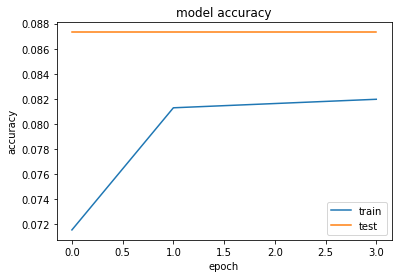

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

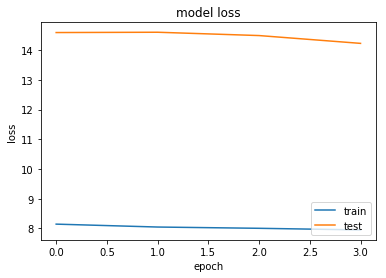

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [17]:
import warnings
from os.path import split

print( "Exporting predictions..")
with open(path+"sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in tqdm(test_images):
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE,3))
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,3))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))

  0%|          | 6/15610 [00:00<04:43, 54.99it/s]

Exporting predictions..


100%|██████████| 15610/15610 [02:58<00:00, 87.66it/s]
